In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense #, Activation
from keras.layers import LSTM

Using TensorFlow backend.


## Vanila LSTM

In [ ]:
# generate array of values

df = pd.DataFrame()
df['t'] = np.arange(50)
# shift forward
df['t+1'] = df['t'].shift(-1)
#print(df)

In [ ]:
x = df['t'].values[:-1]
y = df['t+1'].values[:-1]

In [ ]:
# Normalize data
x = x.reshape((len(x), 1))
y = y.reshape((len(y), 1))

scaler = MinMaxScaler(feature_range=(0, 1))

x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

In [ ]:
#print('Train, test with normalizzation: ', x, y) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
print('Shape of each element at the beginning: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Number of element in X train: ', X_train.shape[0])

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

#print('X Train: ', X_train.shape, X_train) #(6,1,1)
#print('X Test: ', X_test.shape, X_test) (3,1,1)

#print('Y Train: ', y_train.shape, y_train) 
#print('Y Test: ', y_test.shape, y_test)

In [ ]:
model1 = Sequential()
model1.add(LSTM(10, input_shape=(1,1))) #timesteps, features
model1.add(Dense(1))

model1.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

hisoty = model1.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose = 0)

In [ ]:
scores = model1.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))

In [ ]:
prediction = model1.predict(X_test)
#print(prediction)

In [ ]:
real_value_prediction = scaler.inverse_transform(prediction)
real_value = scaler.inverse_transform(y_test)

## Echo Sequence Prediction Problem

 The task is that, given a sequence of random integers as input,
to output the value of a random integer at a specific time input step that is not specified to the
model.


   1. generate a sequence of random numbers
   2. one hot encoder/decoder
   3. data preprocessing 
   4. define and comlpile the model
   5. valuate the model


In [ ]:
# generate random sequence
def generate_random_seq(length, n_features):
    seq = [np.random.randint(0,n_features-1) for x in range(length)]
    return seq

In [ ]:
# encode sequence
def one_hot_encodding(seq, n_features):
    second_step = []
    for element in seq:
        first_step = np.zeros(n_features)
        first_step[element] = 1
        second_step.append(first_step)
    return np.array(second_step)

In [ ]:
# decode sequence
def one_hot_decodding(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [ ]:
# generate one example for an lstm
def generate_example(length, n_features, out_index):
    # generate sequence
    sequence = generate_random_seq(length, n_features)
    # print(sequence)
    # one hot encode
    encoded = one_hot_encodding(sequence, n_features)
    # reshape sequence to be 3D
    X = encoded.reshape((1, length, n_features))
    # select output
    y = encoded[out_index].reshape(1, n_features)
    return X, y

In [ ]:
LENGTH =25
N_FEATURES = 100
OUT_INDEX = 2

In [ ]:
# generate the data
X, y = generate_example(LENGTH, N_FEATURES, OUT_INDEX)
print(X.shape)
print(y.shape)

In [ ]:
# create the model
model = Sequential()
model.add(LSTM(25, input_shape=(LENGTH, N_FEATURES)))
model.add(Dense(N_FEATURES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

In [ ]:
# fit model
for i in range(100):
    X, y = generate_example(LENGTH, N_FEATURES, OUT_INDEX)
    model.fit(X, y, epochs=1, verbose=2)

In [ ]:
# evaluate model–
correct = 0
for i in range(100):
    X, y = generate_example(LENGTH, N_FEATURES, OUT_INDEX)
    yhat = model.predict(X)
    if one_hot_decodding(yhat) == one_hot_decodding(y):
        correct += 1
print('Accuracy:',((correct/100)*100.0))

# Staked LSTM
A Stacked LSTM architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer provides a sequence output rather than a single value output to the LSTM layer below.

In [2]:
# define model where LSTM oputput 3D array, applying return_sequnce=True
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(3,1)))
model.compile(optimizer='adam', loss='mse')
# input time steps
data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1))
# make and show prediction
prediction = model.predict(data)
print(prediction, prediction.shape)

Instructions for updating:
Colocations handled automatically by placer.
[[[0.02427796]
  [0.06747833]
  [0.12313416]]] (1, 3, 1)


####  Time series forecasting using Staked LSTM

Here Staked LSTM (many-to-one) is udsed to create prediction. More precisely, the model will not predict the output time steps piecewise; the whole prediction will be produced at once start from the time sequence data.

To visualize the task and compile the model, the problem of arcsin(sin(x)) will be analize.

In [12]:
from math import sin
from math import pi
from math import exp
from math import asin
from random import random
from random import randint
from random import uniform
from numpy import array
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [13]:
# generate sequence of data - improved model of arcsin(sin(x))
def generate_sequence(length):
    period = randint(0,10)/10
    high = randint(1,10)
    weight = randint(-10,10)
    return [high * asin(sin(i*(pi/4*weight)))/(0.5 + i**period) for i in range(length)]

In [14]:
# generate several sequence of examples:
# length - length of train sequence
# output - length of test sequence
# n_examples - number of sequnce generated at once
def generate_examples(length, output, n_examples):
    X, y = list(), list()
    for _ in range(n_examples):
        sequence = generate_sequence(length + output)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    X = array(X).reshape(n_examples, length, 1)
    y = array(y).reshape(n_examples, output)
    return X, y

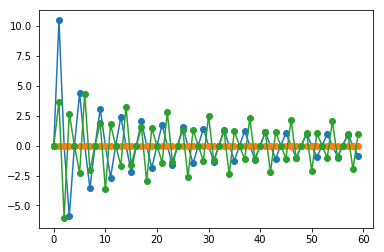

In [56]:
# initial values
LENGTH = 45
OUTPUT = 15
N_EXAMPLES = 3

# check the function
X, y = generate_examples(LENGTH, OUTPUT, N_EXAMPLES)
for i in range(len(X)):
    plt.plot([x for x in X[i, :, 0]] + [x for x in y[i]],  '-o' )
plt.show()

In [57]:
# define model
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(LENGTH, 1)))
model.add(LSTM(20))
model.add(Dense(OUTPUT))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 45, 20)            1760      
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
Total params: 5,355
Trainable params: 5,355
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
# fit model
X, y = generate_examples(LENGTH, OUTPUT, 10000)
history = model.fit(X, y, batch_size=10, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 85s 8ms/step - loss: 0.5218


In [59]:
# evaluate model
X, y = generate_examples(LENGTH, OUTPUT, 1000)
loss = model.evaluate(X, y, verbose=0)
print( 'MAE: ', loss)

MAE:  0.3415452284812927


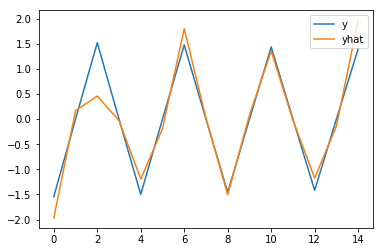

In [60]:
# prediction on new data
X, y = generate_examples(LENGTH, OUTPUT, 1)
yhat = model.predict(X, verbose=0)
pyplot.plot(y[0], label='y' )
pyplot.plot(yhat[0], label='yhat' )
pyplot.legend()
pyplot.show()

In [62]:
y_true = y[0].reshape((OUTPUT,1))
y_prediction = yhat[0].reshape((OUTPUT,1))

In [63]:
y_true = np.concatenate((X[0], y_true), axis=0)
y_prediction = np.concatenate((X[0], y_prediction), axis=0)

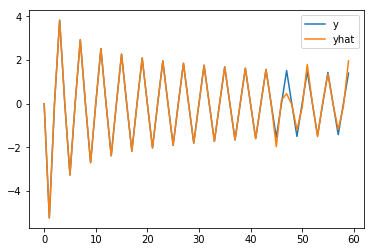

In [64]:
# prediction on new data
pyplot.plot(y_true, label='y' )
pyplot.plot(y_prediction, label='yhat' )
pyplot.legend()
pyplot.show()